# Support Vector Machine and Decision Tree classifiers Notebook

Here we will train Decision Tree and Support Vector Machine classifiers on the covid19 data to predict deaths and hospitalizations. 

In [53]:
import pre_ml
import mlpipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

df = pre_ml.data(False)

Requesting data to datos abiertos Mexico
Getting zip raw data into directory, will delete soon
Raw data deleted. If you specified filename, clean data will be saved in data directory


In [56]:
df.head(5)

,entidad_res,municipio_res,CVE_MUN,embarazo,edad,diabetes,epoc,asma,inmusupr,hipertension,cardiovascular,obesidad,tabaquismo,hospitalizado,muertos,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras
0,2,2,2002,0.0,60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,30.0,69.472275,1.195426,6.639215,18.179678
1,12,1,12001,0.0,43,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,49.1,486.616238,5.340184,9.990545,30.138143
2,14,120,14120,0.0,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,24.6,1232.679739,0.697661,4.074343,11.030027
3,27,4,27004,0.0,53,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,36.3,430.537057,5.448810,13.926240,41.575909
4,27,4,27004,0.0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,36.3,430.537057,5.448810,13.926240,41.575909


## Split into test set / training set and normalize the data

In [60]:
train, test = mlpipeline.split_data(df.loc[:,'embarazo':], .20, seed=0)
train_NORM, test_NORM = mlpipeline.normalize(train, test, ['edad', 'pobreza', 'Densidad_pob', 'medicos',
                                                            'camas_hosp', 'enfermeras'])

In [62]:
train_NORM.head(1)

,embarazo,edad,diabetes,epoc,asma,inmusupr,hipertension,cardiovascular,obesidad,tabaquismo,hospitalizado,muertos,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras
37142,0.0,-1.273145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-0.018532,1.899754,-0.287117,-0.37298,-0.484728


## First we will train a Support Vector Machine Classifier to predict deaths and then hospitalizations

https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c

In [63]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
X_train_NORM = train_NORM.loc[:, features]
y_train = train_NORM.loc[:, 'muertos']

X_test_NORM = test_NORM.loc[:, features]
y_test = test_NORM.loc[:, 'muertos']

In [80]:
y_test.value_counts()

0    14452
1     1828
Name: muertos, dtype: int64

Our data is highly imbalanced, only around 10% (consistent with the average death rate by state) of cases in the training set result in deaths. We will address this with over\under sampling techniques to address this.

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

## Upsampling

In [83]:
from sklearn.utils import resample
negatives = train_NORM[train_NORM.muertos == 0]
positives = train_NORM[train_NORM.muertos == 1]

upsample_positives = resample(positives,
                              replace=True, # sample with replacement
                              n_samples=len(negatives) // 2, # match number in majority class
                              random_state=0)
upsampled_train_NORM = pd.concat([negatives, upsample_positives])

In [84]:
upsampled_train_NORM.muertos.value_counts()

0    57904
1    28952
Name: muertos, dtype: int64

In [85]:
X_upsamp_train_NORM = upsampled_train_NORM.loc[:, features]
y_upsamp_train = upsampled_train_NORM.loc[:, 'muertos']

In [88]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
paramgrid = {'C': [0.1, 1, 10, 100],
             'penalty':['l1', 'l2']} 

grid_search = GridSearchCV(estimator=LinearSVC(random_state=0, max_iter=10000, dual=False),
                           param_grid=paramgrid, cv=10,
                           return_train_score=True,
                           scoring=['accuracy', 'precision', 'recall'], 
                           refit='accuracy')
grid_search.fit(X_upsamp_train_NORM, y_upsamp_train)
cv_results_df = pd.DataFrame(grid_search.cv_results_)

#### Results when upsampling positive label:

In [90]:
cols = ['params', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_precision',
        'rank_test_precision', 'mean_test_recall', 'rank_test_recall']
cv_results_df[cols].sort_values(by='rank_test_accuracy', ascending=True)

,params,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
1,"{'C': 0.1, 'penalty': 'l2'}",0.730830,1,0.630847,1,0.464044,2
2,"{'C': 1, 'penalty': 'l1'}",0.730807,2,0.630790,2,0.464044,2
0,"{'C': 0.1, 'penalty': 'l1'}",0.730784,3,0.630719,4,0.464078,1
4,"{'C': 10, 'penalty': 'l1'}",0.730773,4,0.630724,3,0.463975,6
5,"{'C': 10, 'penalty': 'l2'}",0.730773,4,0.630713,5,0.464009,4
7,"{'C': 100, 'penalty': 'l2'}",0.730773,4,0.630713,5,0.464009,4
6,"{'C': 100, 'penalty': 'l1'}",0.730761,7,0.630695,8,0.463975,6
3,"{'C': 1, 'penalty': 'l2'}",0.730761,8,0.630696,7,0.463975,6


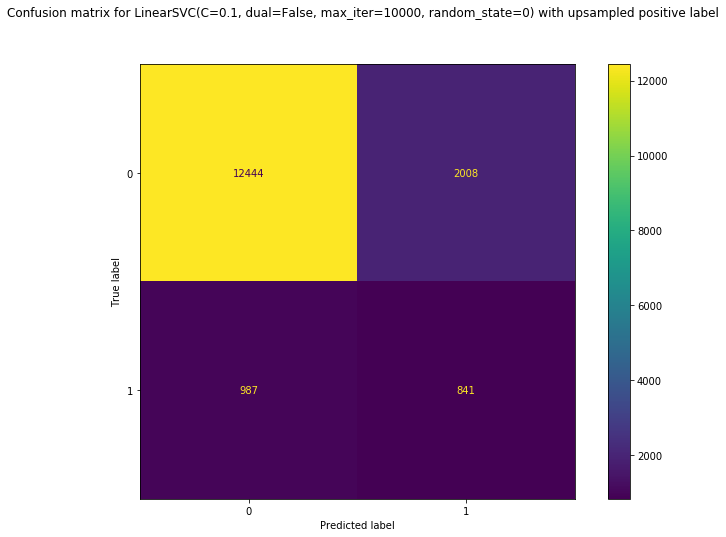

In [98]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
y_predicted = grid_search.best_estimator_.predict(X_test_NORM)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(grid_search.best_estimator_)+' with upsampled positive label');
plot_confusion_matrix(grid_search.best_estimator_, X_test_NORM,y_test, ax=ax);

In [101]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(sklearn.metrics.accuracy_score(y_test, y_predicted),
                       sklearn.metrics.precision_score(y_test, y_predicted), 
                       sklearn.metrics.recall_score(y_test, y_predicted),
                       sklearn.metrics.f1_score(y_test, y_predicted)))

Accuracy: 0.816031941031941
Precision: 0.29519129519129517
Recall: 0.4600656455142232
F1 Score: 0.35963224289074197


## Undersampling

In [104]:
undersample_negatives = resample(negatives,
                                 replace=True, # sample with replacement
                                 n_samples=len(positives), # match number in majority class
                                 random_state=0)
undersample_train_NORM = pd.concat([positives, undersample_negatives])

X_undersamp_train_NORM = undersample_train_NORM.loc[:, features]
y_undersamp_train = undersample_train_NORM.loc[:, 'muertos']

In [105]:
grid_search = GridSearchCV(estimator=LinearSVC(random_state=0, max_iter=10000, dual=False),
                           param_grid=paramgrid, cv=10,
                           return_train_score=True,
                           scoring=['accuracy', 'precision', 'recall'], 
                           refit='accuracy')
grid_search.fit(X_undersamp_train_NORM, y_undersamp_train)
cv_results_df = pd.DataFrame(grid_search.cv_results_)

### Results when undersampling negative label

In [106]:
cols = ['params', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_precision',
        'rank_test_precision', 'mean_test_recall', 'rank_test_recall']
cv_results_df[cols].sort_values(by='rank_test_accuracy', ascending=True)

,params,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
1,"{'C': 0.1, 'penalty': 'l2'}",0.723253,1,0.722703,6,0.724638,1
3,"{'C': 1, 'penalty': 'l2'}",0.723253,1,0.722761,1,0.724499,3
4,"{'C': 10, 'penalty': 'l1'}",0.723253,1,0.722761,1,0.724499,3
5,"{'C': 10, 'penalty': 'l2'}",0.723253,1,0.722761,1,0.724499,3
6,"{'C': 100, 'penalty': 'l1'}",0.723253,1,0.722761,1,0.724499,3
7,"{'C': 100, 'penalty': 'l2'}",0.723253,1,0.722761,1,0.724499,3
2,"{'C': 1, 'penalty': 'l1'}",0.723184,7,0.722664,7,0.724499,3
0,"{'C': 0.1, 'penalty': 'l1'}",0.723184,8,0.722613,8,0.724637,2


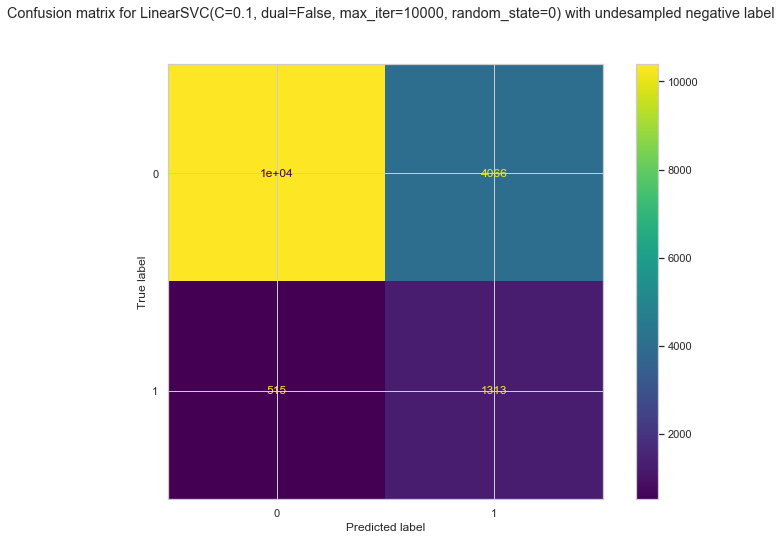

In [117]:
y_predicted = grid_search.best_estimator_.predict(X_test_NORM)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(grid_search.best_estimator_)+' with undesampled negative label');
plot_confusion_matrix(grid_search.best_estimator_, X_test_NORM,y_test, ax=ax);

In [108]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(sklearn.metrics.accuracy_score(y_test, y_predicted),
                       sklearn.metrics.precision_score(y_test, y_predicted), 
                       sklearn.metrics.recall_score(y_test, y_predicted),
                       sklearn.metrics.f1_score(y_test, y_predicted)))

Accuracy: 0.7186117936117936
Precision: 0.24409741587655698
Recall: 0.7182713347921226
F1 Score: 0.3643679755792979


In [114]:
coeffs = pd.DataFrame.from_dict({'predictor':features,
                                 'coefficient':grid_search.best_estimator_.coef_.flatten(),
                                 'abs_coeffient':abs(grid_search.best_estimator_.coef_.flatten())})
coeffs.sort_values(by='abs_coeffient', inplace=True,ascending=False)

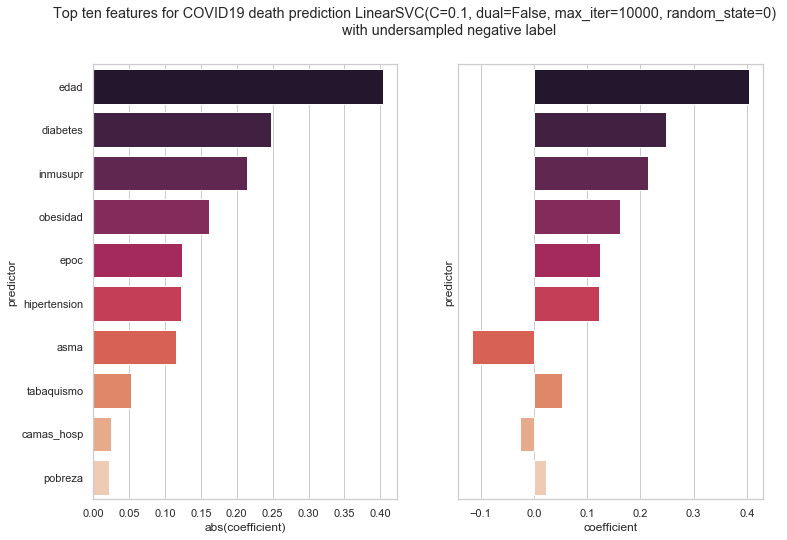

In [122]:
sns.set(style="whitegrid") 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 8)
plt.suptitle('''Top ten features for COVID19 death prediction {} 
                with undersampled negative label'''.format(grid_search.best_estimator_))

plt.sca(ax[0])
sns.barplot(x="abs_coeffient", y="predictor", data=coeffs[0:10],
            palette="rocket")
ax[0].set_xlabel('abs(coefficient)')

plt.sca(ax[1])
sns.barplot(x="coefficient", y="predictor", data=coeffs[0:10],
            palette="rocket")
plt.setp(ax[1],yticks=[]);

## Generate synthetic samples (Synthetic Minority Oversampling Technique)

#missing